In [2]:
import sys
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install torchvision
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

#import warnings
#warnings.filterwarnings('ignore')

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


Detect if GPU available, otherwise use CPU

In [3]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)

cpu


Load MNIST dataset of $28 \times 28$ images. Training does NOT use the test set.

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

1.3%

100.0%


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100.0%
21.9%

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100.0%
100.0%


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [5]:
def imshow(img):
    '''
    Visualizes IMG.
    IMG should be a 2D torch Tensor.
    '''
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(npimg, cmap='gray')
    plt.show()

# Primal Network

This is the definition of the neural classifier for a custom number of layers (depth) and width. The first layer has $28 \times 28$ features, and the output layer has ten output classes (0-9).

In [6]:
class Net(nn.Module):
  
  #Constructor with default NN width = 256 and default NN depth = 3
  def __init__(self, width=256, depth=3):
    super().__init__()
    self.layers = nn.ModuleList()
    self.width = width
    self.depth = depth
    for w in range(0, depth - 1):
      if w == 0:
        self.layers.append(nn.Linear(in_features = 28*28, out_features = width))
      elif w == depth - 2:
        self.layers.append(nn.Linear(in_features = width, out_features = 10))   
      else:
        self.layers.append(nn.Linear(in_features = width, out_features = width))
  
  def forward(self, t):
    '''
    On input T, performs a affine transformation, then
    a ReLU, then another affine transformation.
    '''
    self.z = []
    
    t = t.reshape(-1, 28*28)
    for i in range(0, self.depth - 1):
      t = self.layers[i](t)
      self.z.append(t)
      if i != self.depth - 2:
        t = F.relu(t)
    return t
  

Provided training code using Adam.

In [7]:
def train(net, criterion, trainloader, lr=0.001):
    '''
    Uses the Adam optimization algorithm to train 
    the classifier NET on training data from TRAINLOADER,
    on loss function CRITERION, with learning rate LR.
    
    Note that we half the learning rate each epoch.
    '''
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    for epoch in range(1): #Only training over 1 epoch due to computing time for dual network; want to ensure consistency between networks; increase this number if able to increase dual network training speed or have a processor faster than mac M1
        for i, data in enumerate(trainloader, 0):
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * 0.5 ** (epoch)

            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            if i % 500 == 0:
                print('Epoch', epoch, 'Iter:', i, 'Loss', loss.item())

Train the network using cross entropy loss. Note that this is equivalent to maximizing the KL-divergence.

In [100]:
net = Net(width=256, depth=6)
net.to(device)

criterion = nn.CrossEntropyLoss()

train(net, criterion, trainloader, 0.001)

Epoch 0 Iter: 0 Loss 2.305732488632202
Epoch 0 Iter: 500 Loss 0.4352759122848511
Epoch 0 Iter: 1000 Loss 0.14296230673789978
Epoch 0 Iter: 1500 Loss 0.6010450720787048
Epoch 0 Iter: 2000 Loss 0.21299441158771515
Epoch 0 Iter: 2500 Loss 0.023116540163755417
Epoch 0 Iter: 3000 Loss 0.10639624297618866
Epoch 0 Iter: 3500 Loss 0.4212197959423065
Epoch 0 Iter: 4000 Loss 1.0633115768432617
Epoch 0 Iter: 4500 Loss 0.04488852620124817
Epoch 0 Iter: 5000 Loss 0.15409885346889496
Epoch 0 Iter: 5500 Loss 1.2745575904846191
Epoch 0 Iter: 6000 Loss 0.669056236743927
Epoch 0 Iter: 6500 Loss 0.042474325746297836
Epoch 0 Iter: 7000 Loss 0.01751551404595375
Epoch 0 Iter: 7500 Loss 0.22609339654445648
Epoch 0 Iter: 8000 Loss 0.00718820933252573
Epoch 0 Iter: 8500 Loss 0.4030461013317108
Epoch 0 Iter: 9000 Loss 0.0430266335606575
Epoch 0 Iter: 9500 Loss 0.002445101272314787
Epoch 0 Iter: 10000 Loss 0.014246517792344093
Epoch 0 Iter: 10500 Loss 0.0028894981369376183
Epoch 0 Iter: 11000 Loss 1.747256517410

In [101]:
test_iter = iter(testloader)

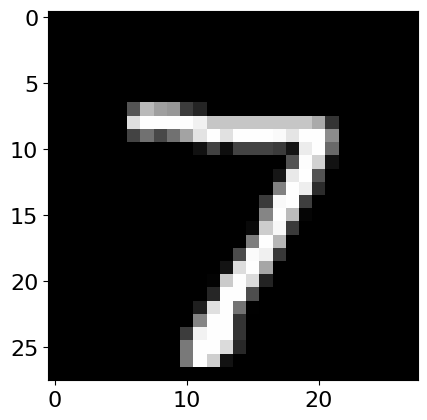

Classifier output: tensor([[ -7.4836,  -5.6392,  -2.3456,  -3.1104,  -8.9156,  -5.9241, -12.9463,
           1.9101,  -4.3092,  -2.2579]])
Classifier prediction: 7


In [102]:
x, labels = next(test_iter)
x = x[0].unsqueeze(0)
labels = labels[0].unsqueeze(0)
imshow(x[0,0])

x = x.to(device)
labels = labels.to(device)

out = net(x).data
print('Classifier output:', out)
print('Classifier prediction:', torch.argmax(out).item())

Let's look at accuracy now.

In [103]:
def accuracy(net, testloader):
    '''
    Returns the accuracy of classifier NET
    on test data from TESTLOADER.
    '''
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [104]:
print('Classifier accuracy on original test dataset:', accuracy(net, testloader))

Classifier accuracy on original test dataset: 0.9323


Implement FGSM Method:

In [105]:
def FGSM(x, labels, net, eps):
    '''
    Given an input image X and its corresponding labels
    LABELS, as well as a classifier NET, returns X
    perturbed by EPS using the fast gradient sign method.
    '''
    net.zero_grad()    # Zero out any gradients from before
    x.requires_grad=True    # Keep track of gradients
    out = net(x)    # Output of classifier
    criterion = nn.CrossEntropyLoss()
    loss = criterion(out, labels)   # Classifier's loss
    loss.backward()
    grads = x.grad.data    # Gradient of loss w/r/t input
    return x + eps*torch.sign(grads)

Now we define an epsilon value for FGSM perturbation:

In [106]:
eps = 0.05

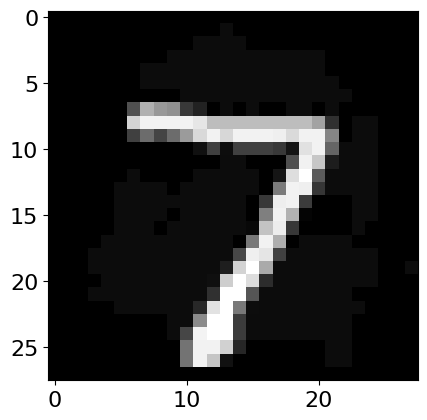

Classifier output: tensor([[ -5.7135,  -5.6740,  -0.7702,  -3.2413,  -7.7999,  -5.9304, -11.2253,
           1.1622,  -3.6171,  -2.4338]])
Classifier prediction: 7


In [107]:
# We are using the same sample input x as before.
x.requires_grad = True
x_prime = FGSM(x, labels, net, eps)
imshow(x_prime[0,0].cpu())
out = net(x_prime)

print('Classifier output:', out.data)
print('Classifier prediction:', torch.argmax(out).item())

In [108]:
for i in range(10):
    c = torch.zeros(10, 1).to(device)
    if i != labels:
        c[i] = -1
        c[labels] = 1
        print(i, (out @ c).item())

0 6.8757243156433105
1 6.836151123046875
2 1.9323625564575195
3 4.403486728668213
4 8.962048530578613
5 7.092589378356934
6 12.387470245361328
8 4.779284477233887
9 3.5959692001342773


In [109]:
def accuracy_on_FGSM(net, testloader, eps):
    '''
    Returns the accuracy of classifier NET on test
    data from TESTLOADER that has been perturbed by
    EPS using FSGM.
    '''
    correct = 0
    total = 0
    for data in testloader:
        x, labels = data[0].to(device), data[1].to(device)
        x_prime = FGSM(x, labels, net, eps)
        outputs = net(x_prime)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return correct / total

In [110]:
print('Classifier accuracy on test dataset perturbed with FGSM:', accuracy_on_FGSM(net, testloader, eps))

Classifier accuracy on test dataset perturbed with FGSM: 0.8218


# Dual Network

In [262]:
def dual_bounds(x, net, eps):
    '''
    Given a classifier NET, an input image X,
    and the epsilon parameter EPS, returns the lower
    and upper bounds L and U respectively, as well as
    the corresponding sets S, S_MIN, S_PLUS.
    '''
    x = x[0].reshape(-1, 1)    # Reshape input to more convenient dimensions
    W = [layer.weight for layer in net.layers]    # Array of network weights (W matrices)
    b = [layer.bias.reshape(-1, 1) for layer in net.layers]    # Array of network biases (b vectors)
    n = W[1].shape[1]    # Dimensionality of hidden layer

    U = []
    L = []
    S = []
    S_plus = []
    S_min = []

    for j in range(0, net.depth - 2):

        u = torch.Tensor([W[0][i] @ x + b[j][i] + eps * torch.norm(W[0][i], 1) for i in range(0, n)])
        l = torch.Tensor([W[0][i] @ x + b[j][i] - eps * torch.norm(W[0][i], 1) for i in range(0, n)])
        #u = torch.Tensor([W[j][i] @ net.z[j-1] + b[j][i] + eps * torch.norm(W[j][i], 1) for i in range(0, n)])
        #l = torch.Tensor([W[j][i] @ net.z[j-1] + b[j][i] - eps * torch.norm(W[j][i], 1) for i in range(0, n)])
        
        U.append(u)
        L.append(l)

        s = [i for i in range(0, n) if l[i] <= 0 and u[i] >= 0]
        s_plus = [i for i in range(0, n) if l[i] <= u[i] and l[i] >= 0]
        s_min = [i for i in range(0, n) if u[i] <= 0 and u[i] >= l[i]]
        S.append(s)
        S_plus.append(s_plus)
        S_min.append(s_min)

    return L, U, S, S_min, S_plus

Given the tuple $(l,u,S,S^-,S^+)$, we are ready to calculate the dual objective itself. This function should take in an input image, the classifier, a vector $c$, and the $(l,u,S,S^-,S^+)$ from the previous function in order to output 
$$
d^*(\vec{x}, \vec{c}) = \max_{\vec{\nu}}(-\vec{\hat{\nu}}_1^T\vec{x}-\epsilon||\vec{\hat{\nu}}_1||_1-\sum_{i=1}^{n-1}\vec{\nu}_{i+1}^T\vec{b}_i+\sum_{i=2}^{n-1}\sum_{j \in S_i}l_{ij}ReLU(\vec{\nu}_{ij}))
$$

One efficient way to compute $\vec{\nu}_i$ is to rewrite it as
$$\vec{\nu}_i= D\vec{\hat{\nu}}_i,$$
where $D$ is a diagonal matrix defined  by
$$
D_{jj}=\begin{cases}
0 & j\in S^-\\
\hat{\nu}_{ij} & j\in S^+\\
\dfrac{u_{j}}{u_{j}-l_{j}}\hat{\nu}_{ij} & j\in S.
\end{cases}
$$

In [263]:
# Constructs the diagonal D matrix from the S sets, n (the dimensionality
# of the hidden layer), u, and l.
def StoD(S_min, S_plus, S, n, U, L):
    '''
    Given upper and lower bounds U and L, as well
    as the corresponding sets S_MIN, S_PLUS, and S,
    as well as the dimension of the hidden layer N,
    returns the corresponding diagonal matrix D.
    '''
    D = []
    for i in range(0, net.depth - 2):
        d = []
        for j in range(n):
            if j in S[i]:
                d.append((U[i][j] / (U[i][j] - L[i][j])).item())
            elif j in S_plus[i]:
                d.append(1)
            elif j in S_min[i]:
                d.append(0)
            else:
                assert False, 'StoD error.'
        D.append(torch.diag(torch.Tensor(d)).to(device))

    return D

def dual_forward(x, net, c, eps, L, U, S, S_min, S_plus):
    '''
    Calculates the dual objective for classifier NET with input X
    and dual input C and epsilon parameter S. Depends on lower
    and upper bounds L and U, as well as the corresponding sets
    S, S_MIN, S_PLUS.
    '''
    x = x[0].reshape(-1, 1)    # Reshape input to more convenient dimensions
    W = [layer.weight for layer in net.layers]    # Array of network weights (W matrices)
    b = [layer.bias.reshape(-1, 1) for layer in net.layers]    # Array of network biases (b vectors)
    n = W[1].shape[1]    # Dimensionality of hidden layer
    D = StoD(S_min, S_plus, S, n, U, L)
    nu = []
    nuh = []

    for i in range(0, net.depth - 1):
        if i == 0:
            nu.append(-c)
        else:
            nu.append(D[net.depth - 2 - i] @ nuh[i - 1])
        nuh.append(W[net.depth - 2 - i].T @ nu[i])
    
    nuh = nuh[::-1]
    nu = nu[::-1]
    
    nu_sum = 0
    for i in range(1, net.depth - 1):
        nu_sum += nu[i].T @ b[i]
    
    relu_sum = 0
    for i in range(0, net.depth - 2):
        for j in range(len(nu[i])):
            if j in S[i]:
                relu_sum += L[i][j] * torch.relu(nu[i][j])
    dual = -1 * (nuh[0].T @ x) - eps * (torch.norm(nuh[0], 1)) - nu_sum + relu_sum

    return dual


In [264]:
eps = 0.05

In [265]:
# We are still using the same sample input x as before.
L, U, S, S_min, S_plus = dual_bounds(x, net, eps)

# print(l, u, S, S_min, S_plus)
# Here, we loop through each column c_j defined above, and output the 
# objective value for the dual function with input c.
for i in range(10):
    c = torch.zeros(10, 1).to(device)
    if i != labels:
        c[i] = -1
        c[labels] = 1
        print(i, dual_forward(x, net, c, 0.1, L, U, S, S_min, S_plus).item())

0 -1.3670995235443115
1 -1.2832828760147095
2 -0.7136061787605286
3 -0.9312044978141785
4 -1.9591467380523682
5 -1.1742033958435059
6 -1.000011682510376
8 -1.29392671585083
9 -2.1490113735198975


In [266]:
def robust_loss(x, label, net, eps, criterion):
    '''
    Given a batch of input images X, its corresponding lables LABEL,
    the classifier NET, epsilon value EPS, and original loss
    function CRITERION, returns the robust loss of NET w/r/t
    the original loss function, on the input image.
    '''
    l, u, S, S_min, S_plus = dual_bounds(x, net, eps)
    # We assume there are 10 classes.
    e_y = torch.zeros(10, 1)
    e_y[label] = 1
    c = e_y @ torch.ones(1, 10) - torch.eye(10)
    J = dual_forward(x, net, c, 0.1, l, u, S, S_min, S_plus).unsqueeze(0)
    try:
        temp = criterion(-J, label.unsqueeze(0))
    except:
        temp = criterion(-J, label.unsqueeze(0).expand(1,10))
    return temp

In [267]:
def robust_train(net, criterion, trainloader, eps, lr=0.001):
    '''
    Trains the classifier NET using the robust version
    of the original loss function CRITERION with paramater EPS,
    using training data from TRAINLOADER and with learning rate LR.
    
    Note that we half the learning rate each epoch.
    '''
    optimizer = optim.Adam(net.parameters(), lr=lr)
        
    for epoch in range(1):
        for i, data in enumerate(trainloader, 0):
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * 0.5 ** (epoch)

            inputs, labels = data
            optimizer.zero_grad()
            loss = 0.0
            for k in range(inputs.shape[0]):
                x = inputs[k].unsqueeze(0)
                label = labels[k].unsqueeze(0)
                loss += robust_loss(x, label, net, eps, criterion)
            loss.backward()
            optimizer.step()
            if i % 500 == 0:
                print('Epoch', epoch, 'Iter:', i, 'Loss', loss.item())

In [268]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

In [269]:
net = Net(width=256, depth=6)
net.to(device)

eps = 0.05
criterion = nn.CrossEntropyLoss()

robust_train(net, criterion, trainloader, eps, 0.001)

Epoch 0 Iter: 0 Loss 9.314839363098145
Epoch 0 Iter: 500 Loss 3.744211435317993
Epoch 0 Iter: 1000 Loss 1.9044350385665894
Epoch 0 Iter: 1500 Loss 0.01411038264632225
Epoch 0 Iter: 2000 Loss 1.2873350381851196
Epoch 0 Iter: 2500 Loss 0.09556318074464798
Epoch 0 Iter: 3000 Loss 4.67132568359375
Epoch 0 Iter: 3500 Loss 1.1899360418319702
Epoch 0 Iter: 4000 Loss 0.9404752850532532
Epoch 0 Iter: 4500 Loss 1.9732692241668701
Epoch 0 Iter: 5000 Loss 0.2283797711133957
Epoch 0 Iter: 5500 Loss 0.6562962532043457
Epoch 0 Iter: 6000 Loss 2.325472354888916
Epoch 0 Iter: 6500 Loss 0.2754947543144226
Epoch 0 Iter: 7000 Loss 4.907211780548096
Epoch 0 Iter: 7500 Loss 0.09602998942136765
Epoch 0 Iter: 8000 Loss 2.2070083618164062
Epoch 0 Iter: 8500 Loss 2.8512778282165527
Epoch 0 Iter: 9000 Loss 0.6221646666526794
Epoch 0 Iter: 9500 Loss 0.6932966709136963
Epoch 0 Iter: 10000 Loss 1.90590500831604
Epoch 0 Iter: 10500 Loss 0.030862275511026382
Epoch 0 Iter: 11000 Loss 0.019204840064048767
Epoch 0 Iter:

In [270]:
test_iter = iter(testloader)

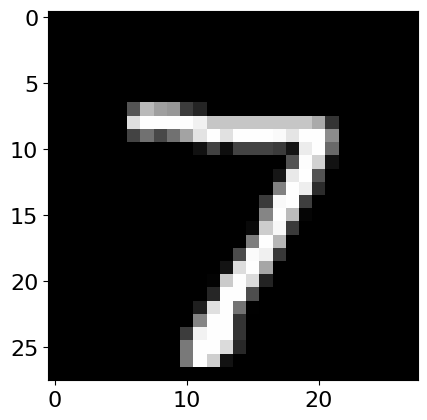

Classifier output: tensor([[ -4.4405,   2.2486,  29.4472, -12.8132,   4.3104, -14.6299, -16.0580,
          13.6417,  -6.1732,  -6.8608]])
Classifier prediction: 2


In [271]:
x, labels = next(test_iter)
x = x[0].unsqueeze(0)
labels = labels[0].unsqueeze(0)
imshow(x[0,0])

x = x.to(device)
labels = labels.to(device)

out = net(x).data
print('Classifier output:', out)
print('Classifier prediction:', torch.argmax(out).item())

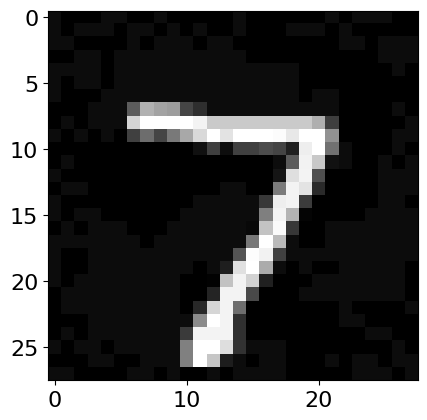

Classifier output: tensor([[-10.2132,   4.6576,  36.6753, -12.0437,   3.9140, -18.4304, -22.6044,
          12.6634,  -8.7376,  -8.8701]])
Classifier prediction: 2


In [272]:
# We are using the same sample input x as before.
x.requires_grad = True
x_prime = FGSM(x, labels, net, eps)
imshow(x_prime[0,0].cpu())
out = net(x_prime)

print('Classifier output:', out.data)
print('Classifier prediction:', torch.argmax(out).item())

In [273]:
def accuracy(net, testloader):
    '''
    Returns the accuracy of classifier NET
    on test data from TESTLOADER.
    '''
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [274]:
print('Classifier accuracy on original test dataset:', accuracy(net, testloader))

Classifier accuracy on original test dataset: 0.5063


In [275]:
def accuracy_on_FGSM(net, testloader, eps):
    '''
    Returns the accuracy of classifier NET on test
    data from TESTLOADER that has been perturbed by
    EPS using FSGM.
    '''
    correct = 0
    total = 0
    for data in testloader:
        x, labels = data[0].to(device), data[1].to(device)
        x_prime = FGSM(x, labels, net, eps)
        outputs = net(x_prime)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return correct / total

In [276]:
print('Classifier accuracy on test dataset perturbed with FGSM:', accuracy_on_FGSM(net, testloader, eps))

Classifier accuracy on test dataset perturbed with FGSM: 0.3928


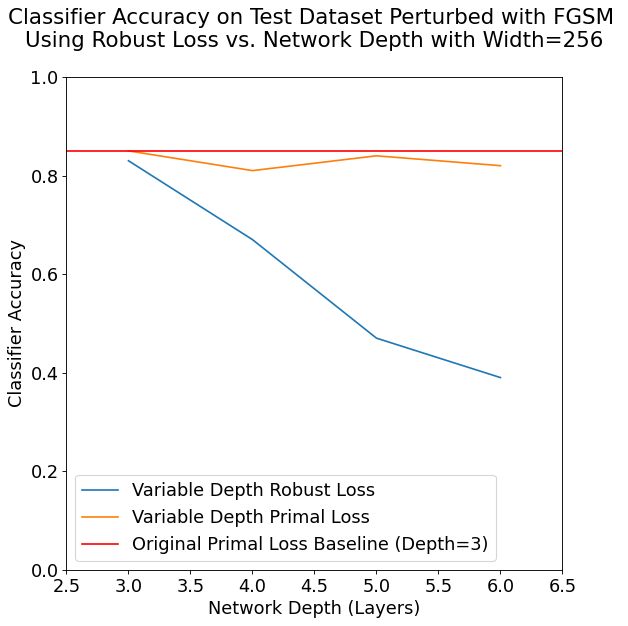

In [111]:
# Data gathered from multiple iterations, updated with each re-run of this script.  Plot below measures classifier accuracy on test dataset perturbed with FGSM 
# relative to width compared to a baseline of width 256 and depth 3.  All runs were with a network of depth 3.

fig1 = plt.figure(figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size':16})

depth_data = [3, 4, 5, 6]
robust_data = [0.83, 0.67, 0.47, 0.39]
original_data = [0.85, 0.81, 0.84, 0.82]

plt.xlim(2.5, 6.5)
plt.ylim(0, 1)

plt.plot(depth_data, robust_data)
plt.plot(depth_data, original_data)
plt.axhline(y=0.85, color='r')

plt.legend(['Variable Depth Robust Loss', 'Variable Depth Primal Loss', 'Original Primal Loss Baseline (Depth=3)'])
plt.title("Classifier Accuracy on Test Dataset Perturbed with FGSM \nUsing Robust Loss vs. Network Depth with Width=256\n")
plt.xlabel("Network Depth (Layers)")
plt.ylabel("Classifier Accuracy")

plt.show()

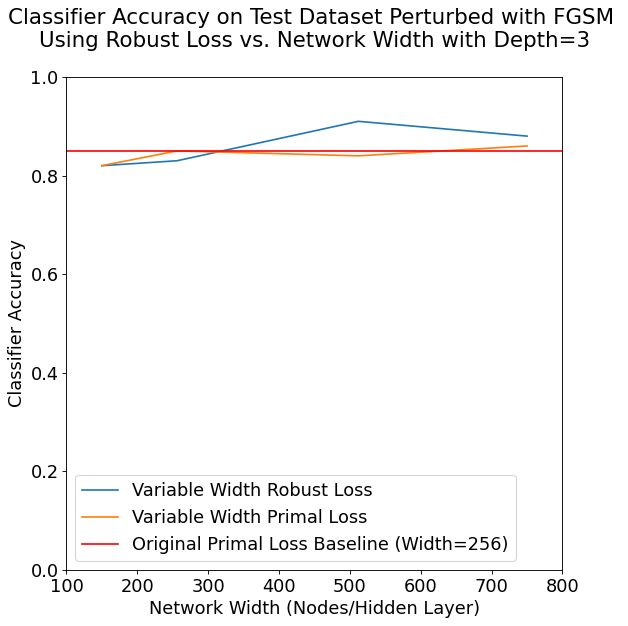

In [98]:
# Data gathered from multiple iterations, updated with each re-run of this script.  Plot below measures classifier accuracy on test dataset perturbed with FGSM 
# relative to width compared to a baseline of width 256 and depth 3.  All runs were with a network of depth 3.

fig1 = plt.figure(figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size':16})

depth_data = [150, 256, 512, 750]
robust_data = [0.82, 0.83, 0.91, 0.88]
original_data = [0.82, 0.85, 0.84, 0.86]

plt.xlim(100, 800)
plt.ylim(0, 1)

plt.plot(depth_data, robust_data)
plt.plot(depth_data, original_data)
plt.axhline(y=0.85, color='r')

plt.legend(['Variable Width Robust Loss', 'Variable Width Primal Loss', 'Original Primal Loss Baseline (Width=256)'])
plt.title("Classifier Accuracy on Test Dataset Perturbed with FGSM \nUsing Robust Loss vs. Network Width with Depth=3\n")
plt.xlabel("Network Width (Nodes/Hidden Layer)")
plt.ylabel("Classifier Accuracy")

plt.show()